In [2]:
from Helpers import *
from FLController import *
from ILQGController import *

In [3]:
def Velocity_dep_FF(x,acc,prop = 10):
    L1,L2 = 30,33
    
    thetas,thetae,omegas,omegae = x
    s1,s2,c1,c2 = sin(thetas),sin(thetas+thetae),cos(thetas),cos(thetas+thetae)
    accs,acce = acc
    ddx = -L1*(c1*omegas*omegas+s1*accs)-L2*(c2*(omegas+omegae)*(omegas+omegae)+s2*(accs+acce))
    ddy = -L1*(s1*omegas*omegas-c1*accs)-L2*(s2*(omegas+omegae)*(omegas+omegae)-c2*(accs+acce))
    dy = prop*(L1*cos(thetas)*omegas+L2*cos(thetas+thetae)*(omegas+omegae))
    ddx+=dy
    gamma1 = -L1*s1*omegas*omegas-L2*s2*(omegas+omegae)*(omegas+omegae)-ddy
    gamma2 = -L1*c1*omegas*omegas-L2*c2*(omegas+omegae)*(omegas+omegae)
    gamma3 = -L1*s1+L1*c1*s2/c2
    new_accs = (ddx-gamma2-gamma1*s2/c2)/gamma3
    new_acce = gamma1/(-L2*c2)-accs*(1+(L1*c1)/(L2*c2))
    F = np.array([new_accs-accs,new_acce-acce])
    return F

def Compute_lateral_acceleration(F,x):
    L1,L2 = 30,33
    thetas,thetae,omegas,omegae = x
    s1,s2,c1,c2 = sin(thetas),sin(thetas+thetae),cos(thetas),cos(thetas+thetae)
    accs,acce = F
    return -L1*(c1*omegas*omegas+s1*accs)-L2*(c2*(omegas+omegae)*(omegas+omegae)+s2*(accs+acce))


In [4]:
def Feedback_Linearization_ACCx(Duration = .6,w1 = 1e8,w2 = 1e8,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,alpha = 1,Activate_Noise = False,Side = "Left",newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 300, ShowJ = False,ShowF = False, ShowEstimate = False,Delay = .06,FF = False,FFonset = 35):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noises in the model

    Side (String) : Side of the force field ("Left" or "Right")
    
    newtonfunc([thetas,thetae],X,Y) : Function that computes the difference between the change of variable from the angular to cartesian system, and the targetted X,Y position
                                      It's a tool for the newton method to compute the desired joint angles that generate a precise X,Y position of the hand

    newtondfunc([thetas,thetae],X,Y) : Derivative of newtonfunc

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = Q

    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B_basic.T@S@B_basic)@B_basic.T@S@A_basic
        array_L[Num_iter-2-k] = L
        S = A_basic.T@S@(A_basic-B_basic@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    new_x = np.copy(x)

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)
    AccX = np.zeros(Num_iter-1)
    AppliedForce = np.zeros(Num_iter-1)
    
    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 
        
        if (np.sin(x[0]+x[1])*33+np.sin(x[0])*30 > FFonset) and (FF == True):

            F=Compute_f_new_version(x[0:2],x[2:4],acc,.3)
            if Side == "Left": F*=-1
            
        else : 
            F = [0,0]
        AccX[k] = Compute_lateral_acceleration(F+acc,x[:4])-Compute_lateral_acceleration(acc,x[:4])
        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,alpha,B)

        C = np.array([-zhat[4]*(2*zhat[1]+zhat[4])*a2*np.sin(zhat[3]),zhat[1]*zhat[1]*a2*np.sin(zhat[3])])

        M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])

        Cdot = np.array([-a2*zhat[5]*(2*zhat[1]+zhat[4])*sin(zhat[3])-a2*zhat[4]*(2*zhat[2]+zhat[5])*sin(zhat[3])
                         -a2*zhat[4]*zhat[4]*(2*zhat[1]+zhat[4])*cos(zhat[3]),2*zhat[1]*zhat[2]*a2*sin(zhat[3])+zhat[1]*zhat[1]*a2*cos(zhat[3])*zhat[4]])

        Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
       
        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(B_basic.shape))@zhat[:Num_Var]
        u = 1/Kfactor*M@(v)+1/Kfactor*Mdot@(np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Bdyn@np.array([zhat[1],zhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([zhat[2],zhat[5]])
        if ShowJ : J+= u.T@R@u
        AppliedForce[k] = Compute_lateral_acceleration(F+acc,x[:4])-Compute_lateral_acceleration(F,x[:4])
        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : y[k]+=measure_noise
        
        # Kalman Filter Gains 

        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T

        # Compute the Estimation of the system in the linear system
        
        zhat = A@zhat + B@v + K@(y[k]-H@zhat)
        
        # Simulate the nonlinear plant 
        
        C = np.array([-x[3]*(2*x[2]+x[3])*a2*np.sin(x[1]),x[2]*x[2]*a2*np.sin(x[1])])
        
        M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])

        
        Cdot = np.array([-a2*acc[1]*(2*x[2]+x[3])*sin(x[1])-a2*x[3]*(2*acc[0]+acc[1])*sin(x[1])
                         -a2*x[3]*x[3]*(2*x[2]+x[3])*cos(x[1]),2*x[2]*acc[0]*a2*sin(x[1])+x[2]*x[2]*a2*cos(x[1])*x[3]])

        Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        
        #print(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))-acc)
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))+F)
        new_x[4:6] += dt*Kfactor*(u-x[4:6])

        if Activate_Noise : new_x+=motor_noise[:6]
        
        # Transform the new nonlinear state into the coordinates of the linear system
        C = np.array([-new_x[3]*(2*new_x[2]+new_x[3])*a2*np.sin(new_x[1]),new_x[2]*new_x[2]*a2*np.sin(new_x[1])])
        
        M = np.array([[a1+2*a2*cos(new_x[1]),a3+a2*cos(new_x[1])],[a3+a2*cos(new_x[1]),a3]])

        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C))+F
        
        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        #J+= z.T@Q@z
        print("Total cost of FL: "+str(J)[:7])

    #Change of coordinates from angular to cartesian 
    

    X = np.cos(array_z[:,0]+array_z[:,3])*33+np.cos(array_z[:,0])*30
    Y = np.sin(array_z[:,0]+array_z[:,3])*33+np.sin(array_z[:,0])*30

    if ShowEstimate:
        X2 = np.cos(array_zhat[:,0]+array_zhat[:,3])*33+np.cos(array_zhat[:,0])*30
        Y2 = np.sin(array_zhat[:,0]+array_zhat[:,3])*33+np.sin(array_zhat[:,0])*30

    #Plotting
    color1 = plt.get_cmap('RdPu')(kdelay*10 / Num_iter)

    if plot : 
        
        plt.grid(linestyle='--')
        #if FF : 
            #plt.plot(np.linspace(-10,10,100),np.ones(100)*FFonset,linestyle = "--",alpha = .7,color = "grey")
        plt.axis("equal")
        color = "cyan"
        ls = "-"
        lw = 3
        if Side == "Right": 
            ls = "--"
            lw = 1
            color = "red"
        if FF == False:
            ls = "-"
            lw = 1
            color = "grey"
        if Delay > 0 : plt.plot(X,Y,color = color,label = "FL movement with "+str(int(kdelay*dt*1000))+ " \n ms delay",linewidth = lw,linestyle = ls)
        else : plt.plot(X,Y,color = "#48494B",label = "Feedback Linearization",linewidth = 1)
        if ShowEstimate: 
            plt.plot(X2,Y2,color ="black",label = "Estimation",linewidth = 1,linestyle = "--",alpha = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "orange",marker = "s" , s = 600, alpha= .3)
    if ShowJ : return X,Y,J,x
    if ShowF : 
        Ydot = np.zeros(Num_iter-1)
        Xdot = np.zeros(Num_iter-1)
        for k in range(Num_iter-1):
            Ydot[k] = (Y[k+1]-Y[k])/dt
            Xdot[k] = (X[k+1]-X[k])/dt
        return Ydot,Xdot,AccX,AppliedForce
    return X,Y

TypeError: Feedback_Linearization() got an unexpected keyword argument 'FF'

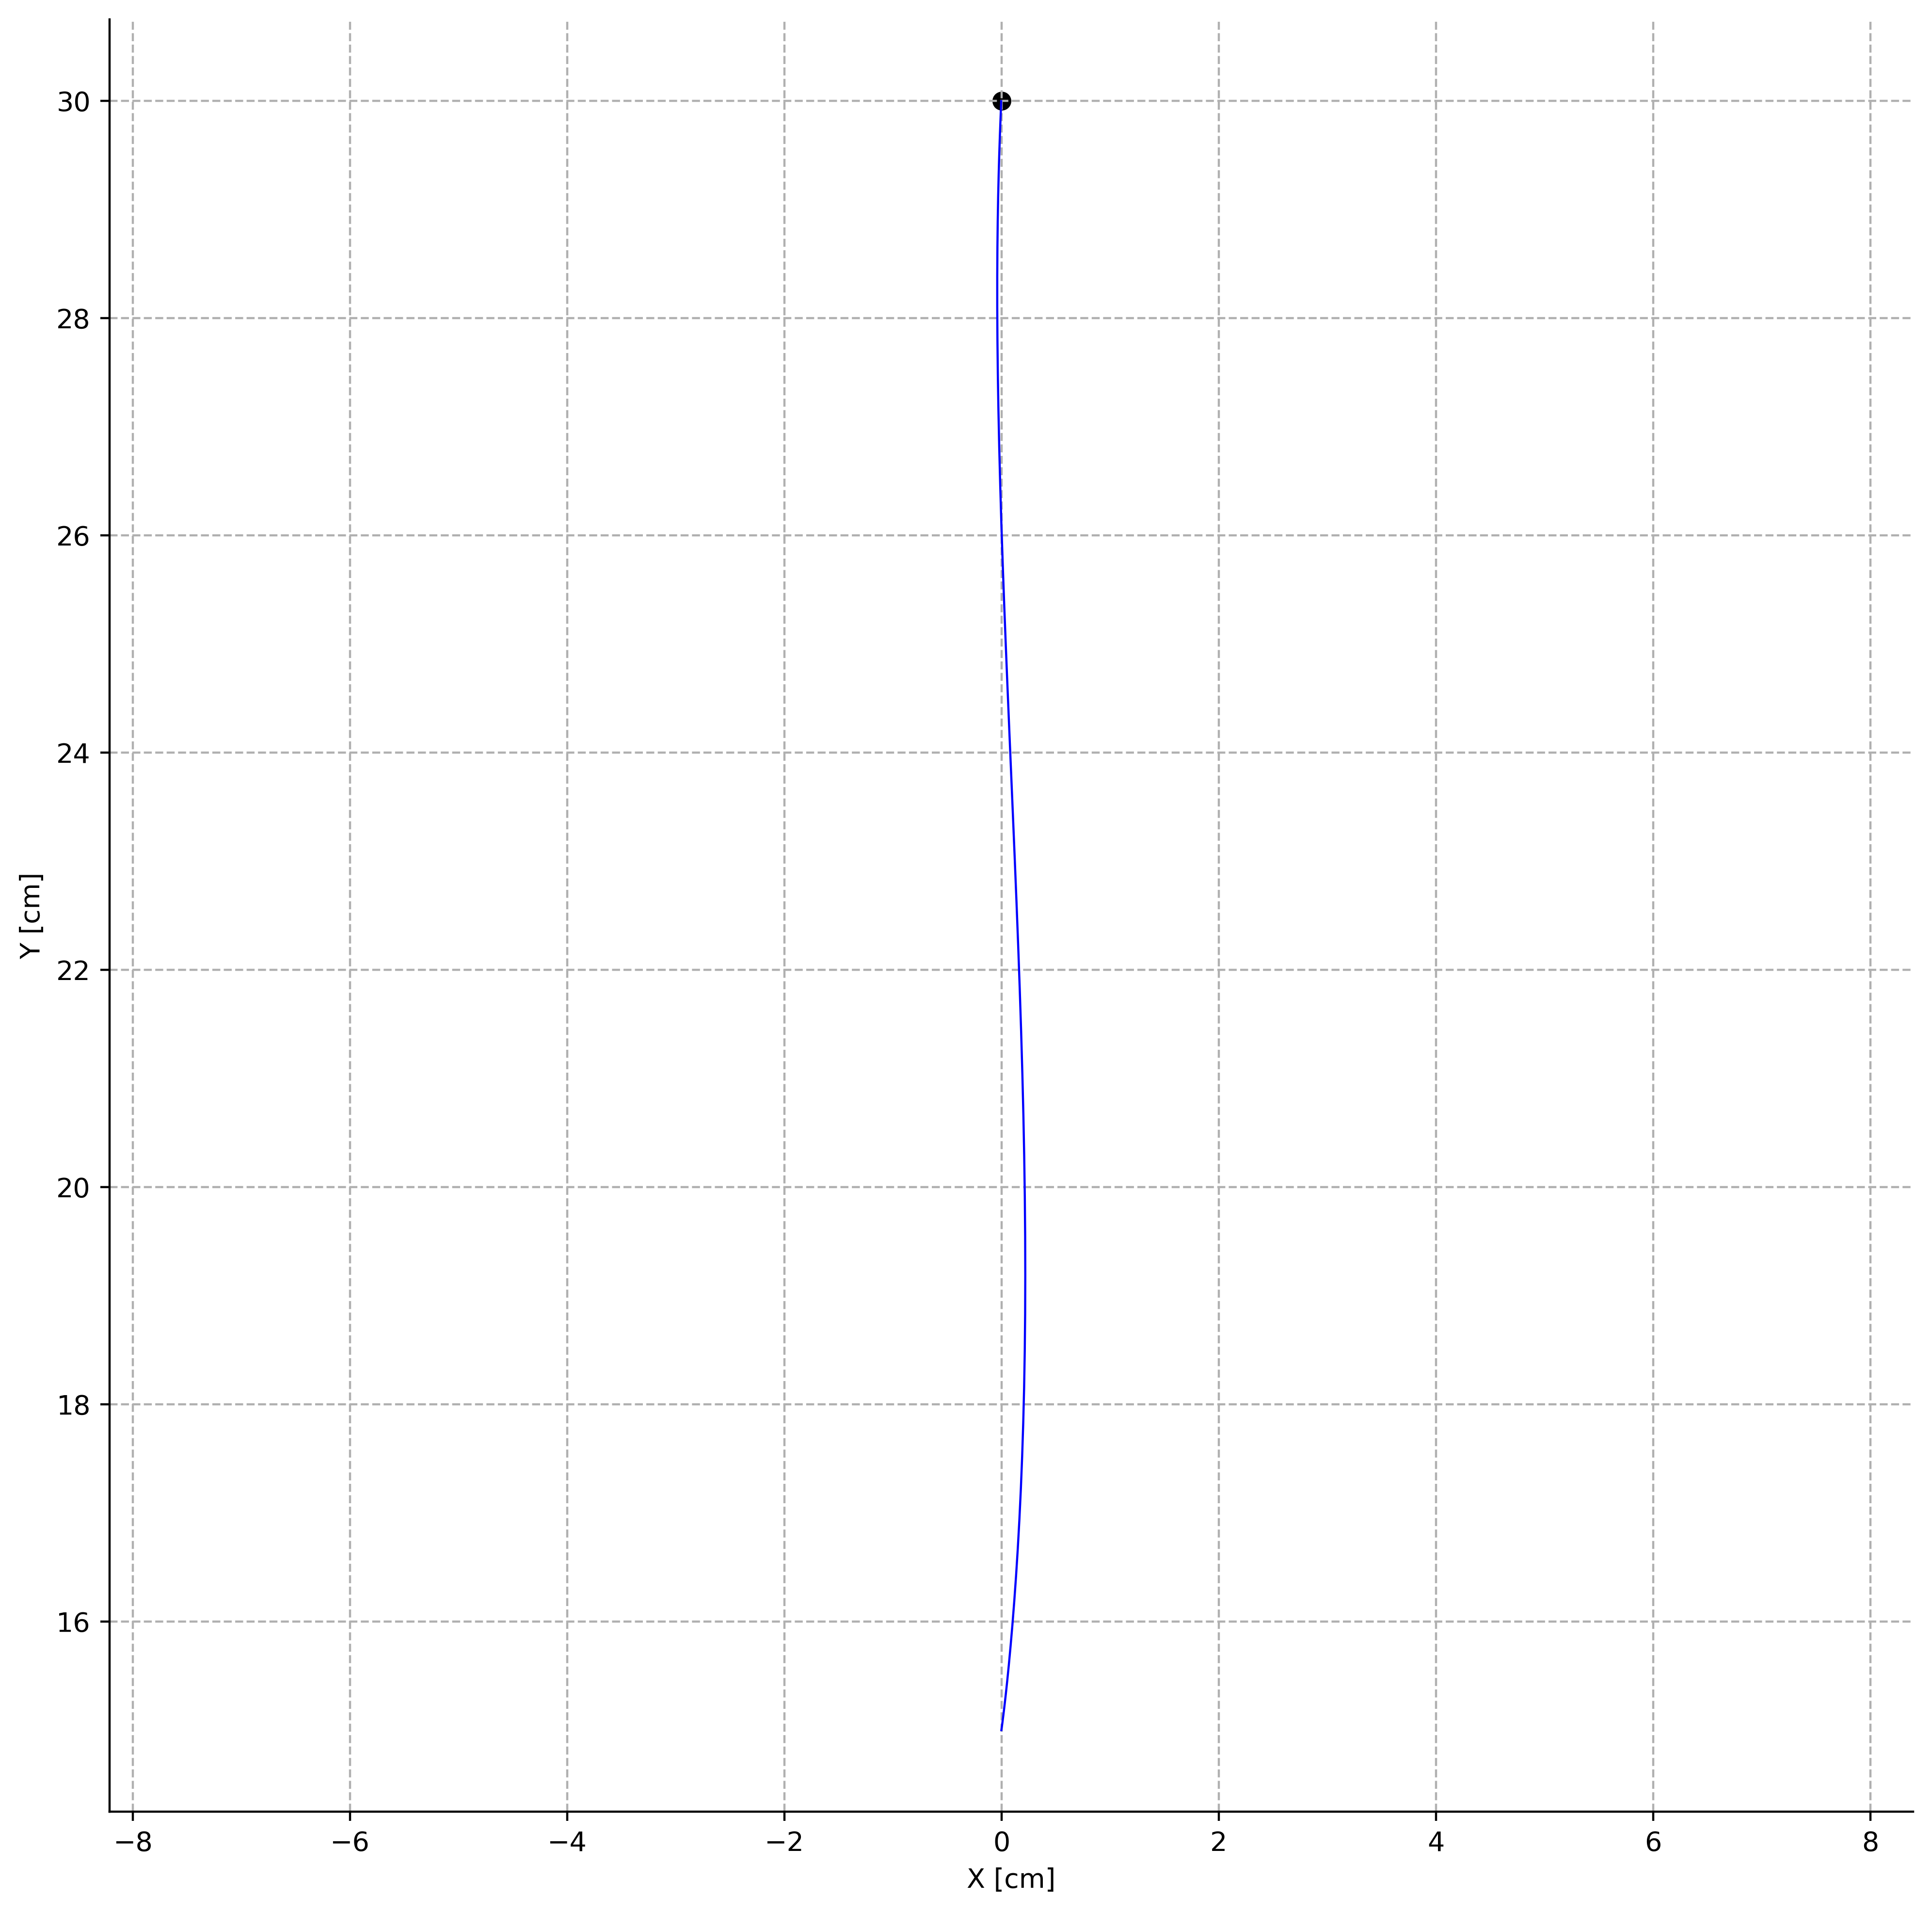

In [5]:
w = 1e5
w2 = 200
r = 1e-5
D = .6
N = 60
d = 15/sqrt(2)
a= 1
L = 15
plt.figure(dpi=400,figsize = (12,12))
for start in np.array([[0,25],[d,40-d],[15,40],[d,40+d],[0,55],[-d,40+d],[-15,40],[-d,40-d]]):
    start -= np.array([0,10])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for side in ["Left","Right"]:
        ILQG(D,w,w2,r,targets = start + np.array([0,L]),start = start,K = N,FF = False)
        Ydot,Xdot = Feedback_Linearization(Duration = D,Num_iter=N,w1 = w,w2 = w,w3=w2,w4=w2,r1=r,r2=r,FF = True,starting_point = start,targets = start + np.array([0,L]),Side = side,FFonset=0,plot= True,Delay=0.06,alpha=a)
    Ydot,Xdot = Feedback_Linearization(Duration = D,Num_iter=N,w1 = w,w2 = w,w3=w2,w4=w2,r1=r,r2=r,starting_point = start,targets = start + np.array([0,L]),FF=False,FFonset=0,plot= True,Delay=0.06,alpha=a)
plt.legend()
MultipleLabel()
    

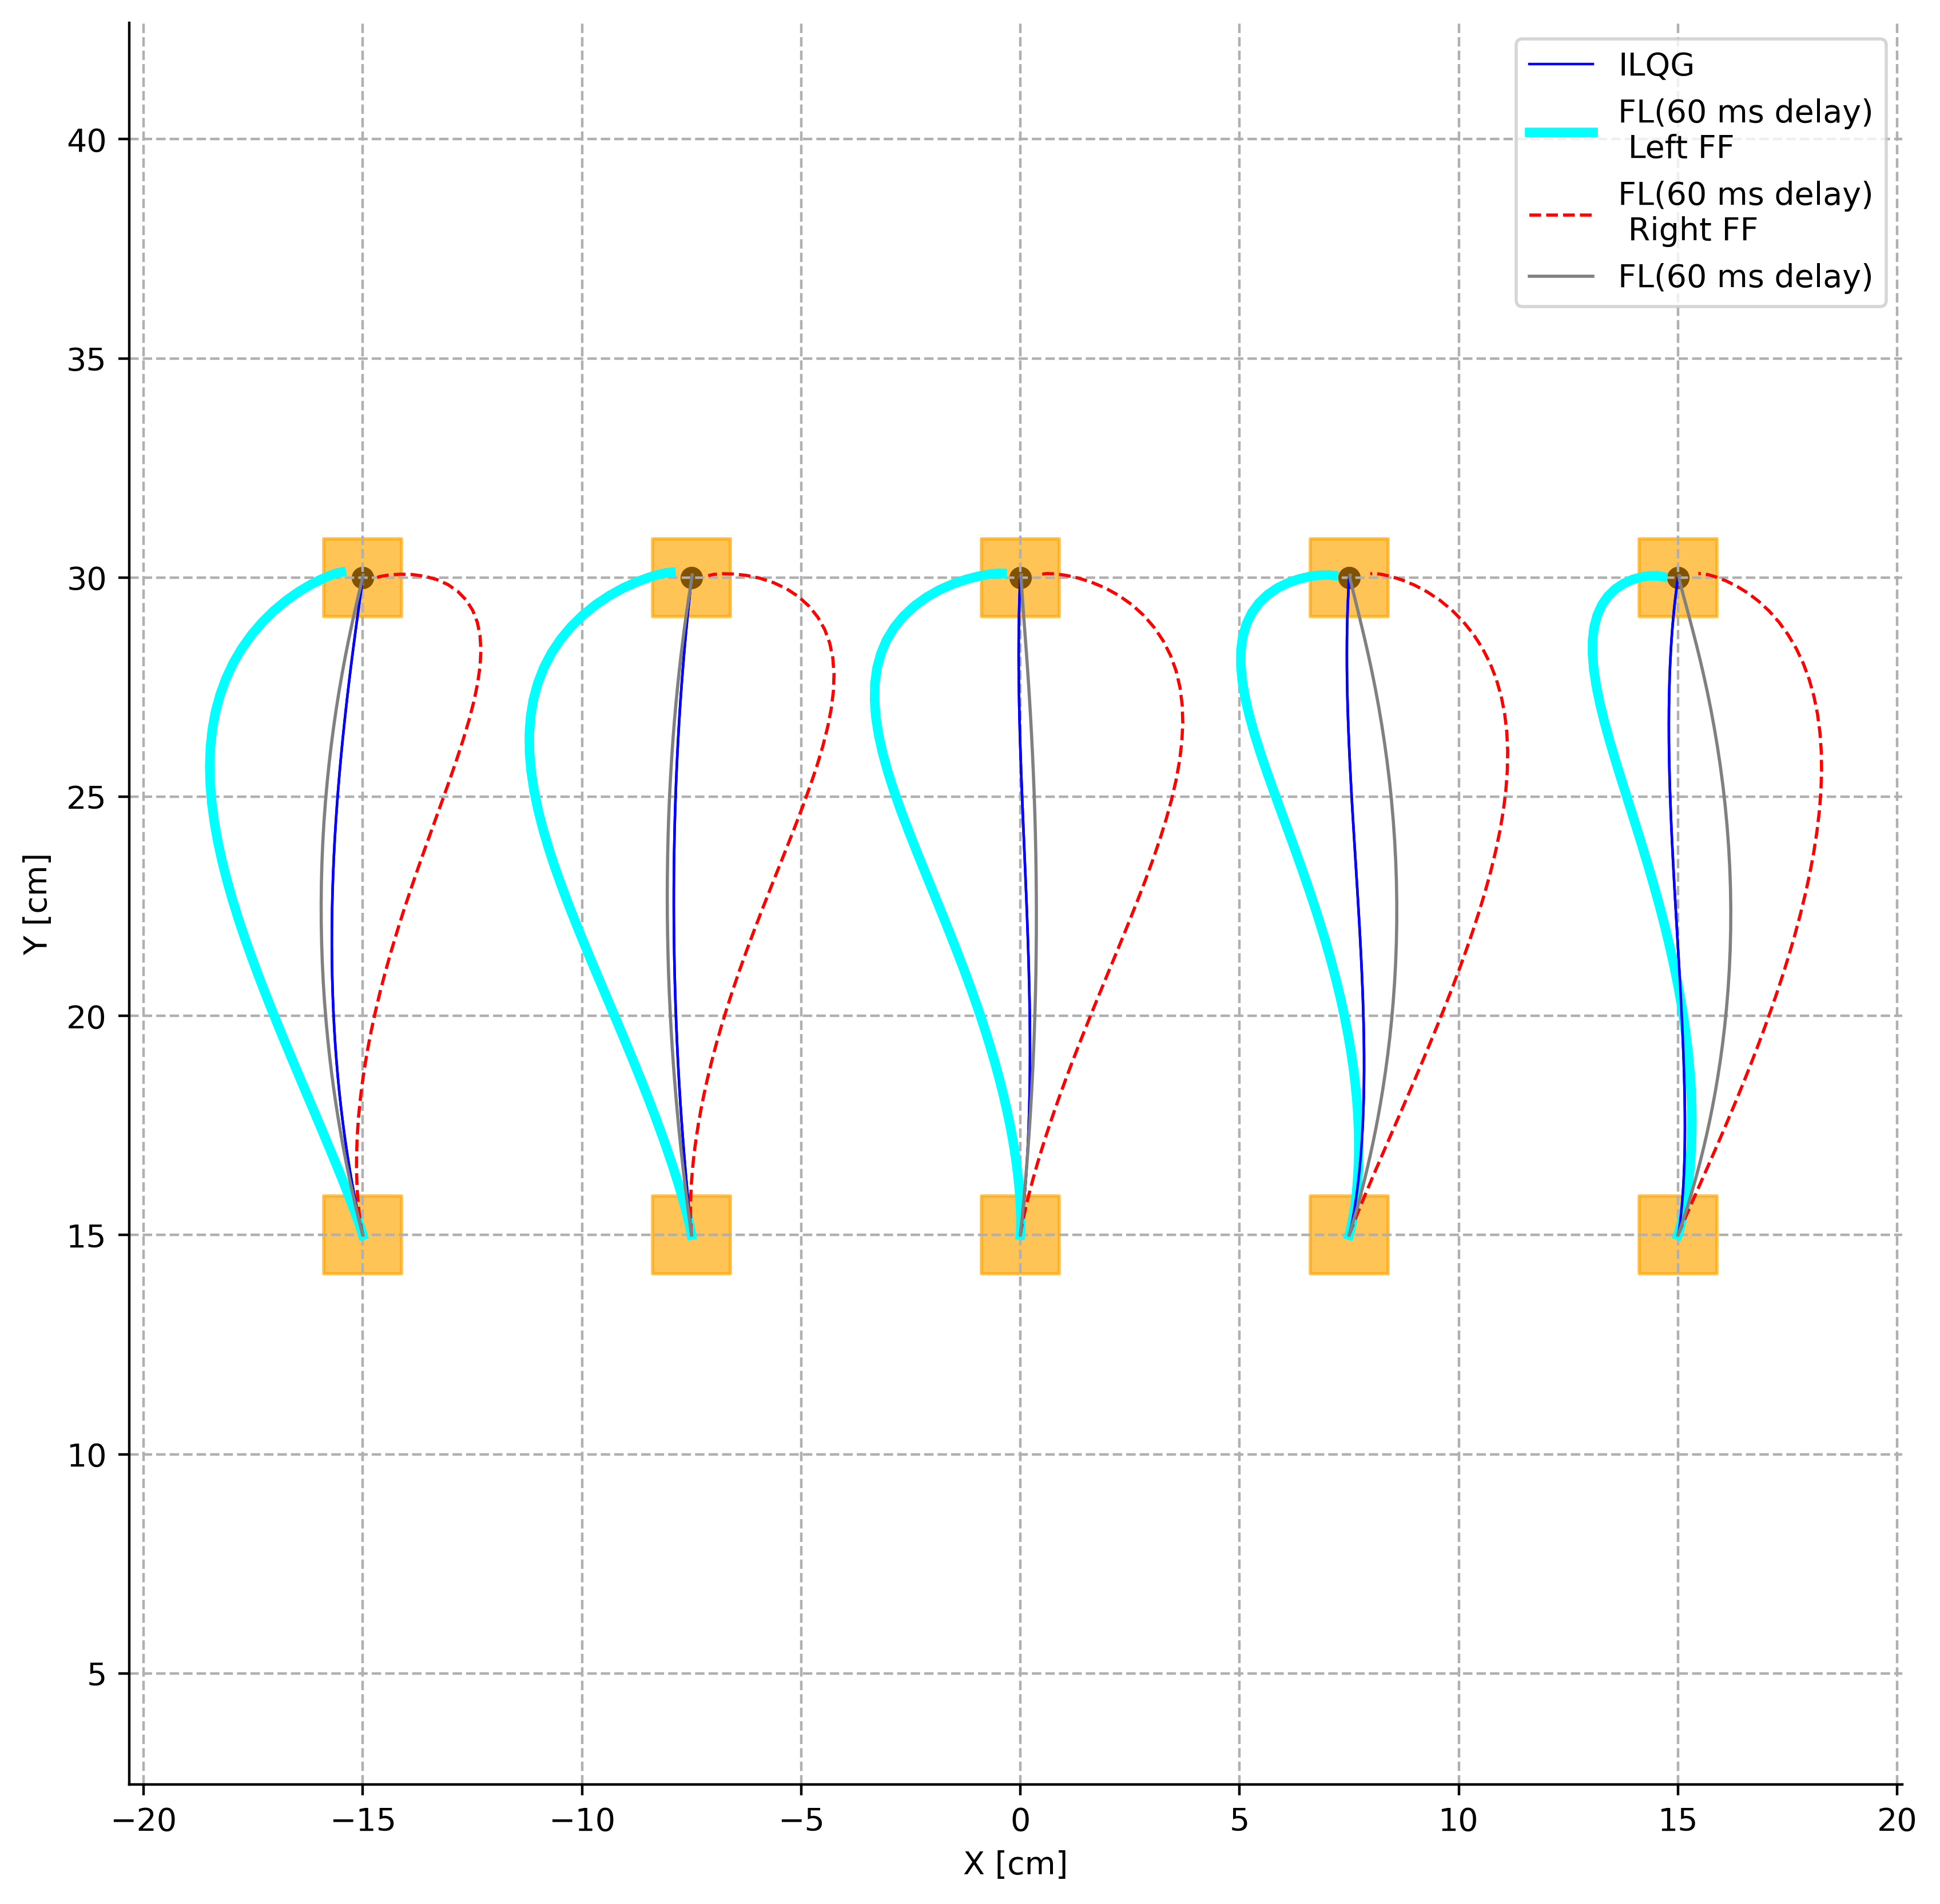

In [7]:
w = 1e5
w2 = 200
r = 1e-5
D = .6
N = 60
a= 1
plt.figure(dpi=400,figsize = (10,10))
for start in np.array([[0,30],[7.5,30],[15,30],[-7.5,30],[-15,30]]):
    start -= np.array([0,15])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for side in ["Left","Right"]:
        ILQG(D,w,w2,r,targets = start + np.array([0,15]),start = start,K = N,FF = False)
        Ydot,Xdot = Feedback_Linearization(Duration = D,Num_iter=N,w1 = w,w2 = w,w3=w2,w4=w2,r1=r,r2=r,FF = True,starting_point = start,targets = start + np.array([0,15]),Side = side,FFonset=0,plot= True,Delay=0.06,alpha=a)
    Ydot,Xdot = Feedback_Linearization(Duration = D,Num_iter=N,w1 = w,w2 = w,w3=w2,w4=w2,r1=r,r2=r,starting_point = start,targets = start + np.array([0,15]),FF=False,FFonset=0,plot= True,Delay=0.06,alpha=a)
plt.legend()
MultipleLabel()
    

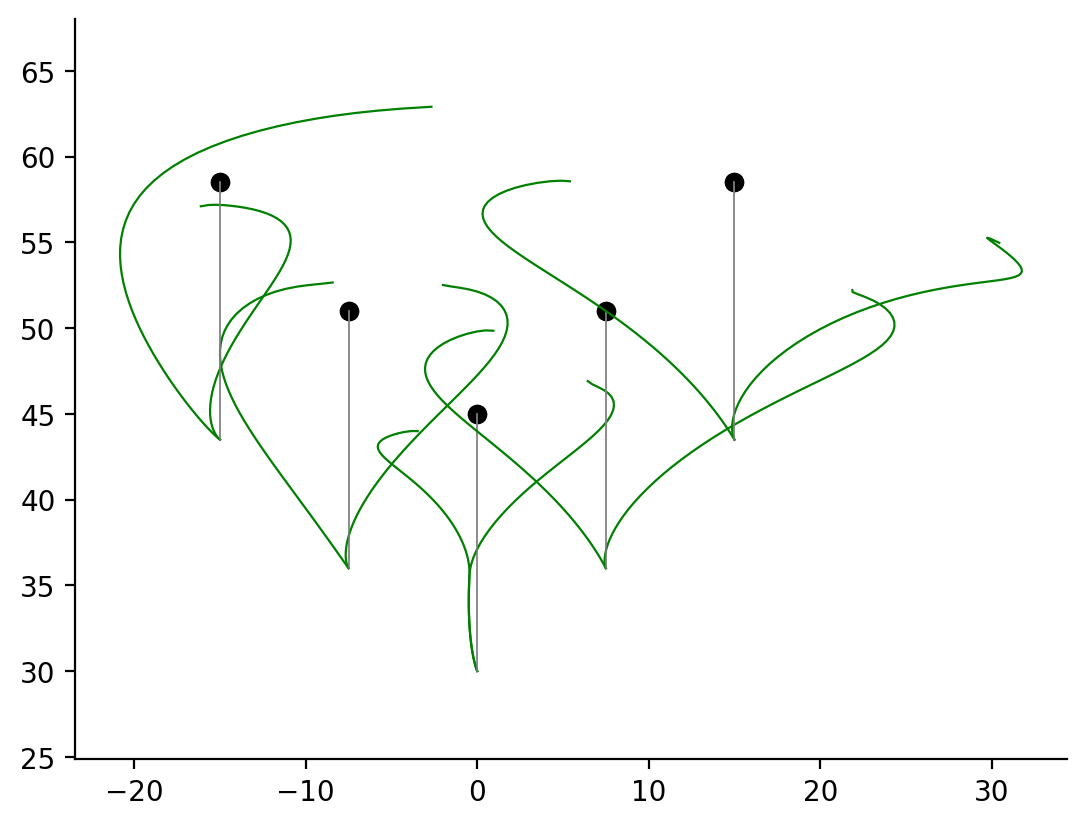

In [8]:
from LQGController import *
w = 1e6
w2 = 200
r = 1e-5
D = .6
N = 60
plt.figure(dpi=200)
for start in np.array([[0,30],[7.5,36],[15,43.5],[-7.5,36],[-15,43.5]]):
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for side in ["Left","Right"]:
        
        Ydot,Xdot,AccX = LQG(Duration = D,Num_iter=N,w1 = w,w2 = w,w3=w2,w4=w2,r1=r,r2=r,FF = True,starting_point = start,targets = start + np.array([0,15]),Side = side,plot= True,Delay=0.06)
        plt.plot(np.ones(100)*start[0],np.linspace(start[1],start[1]+15,100),color = "grey",linewidth = .6,alpha = .8)

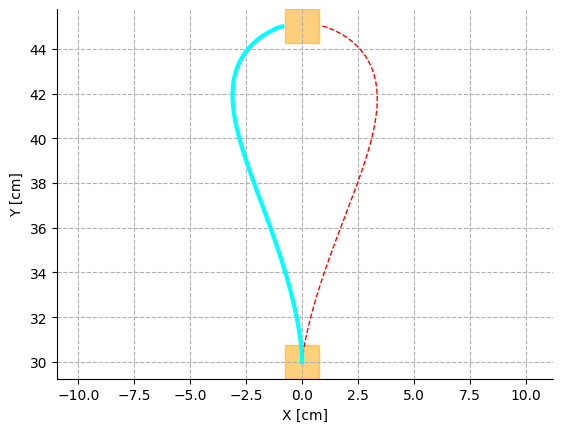

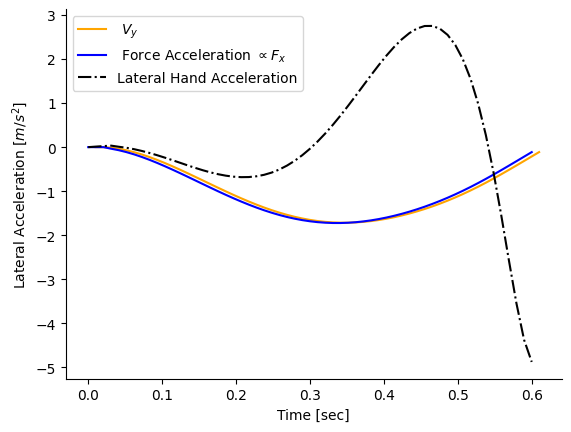

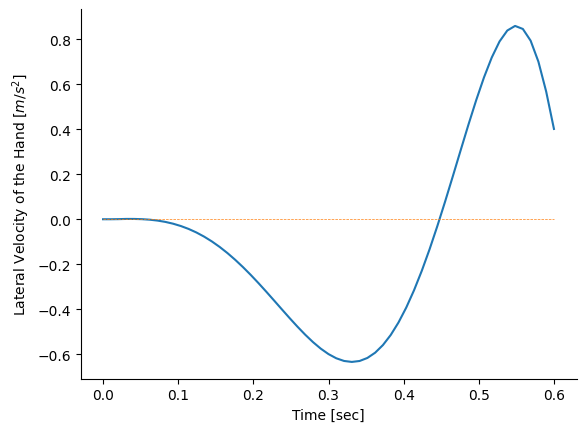

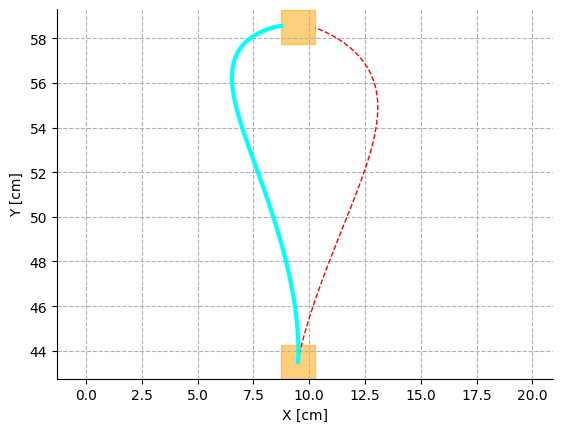

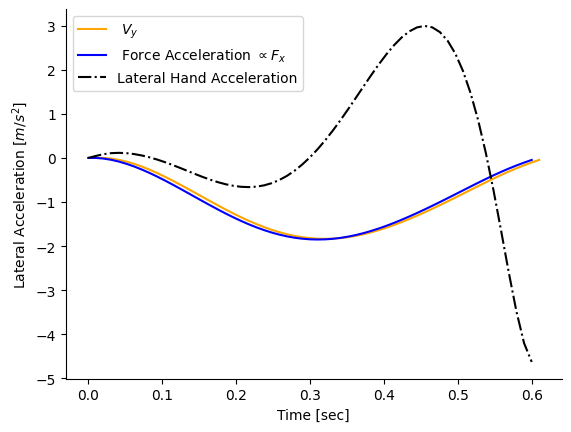

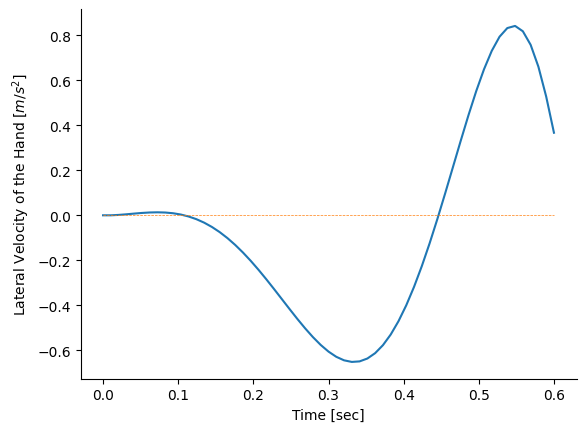

In [10]:
w = 1e5
w2 = 1e2
r = 1e-5
D = .6
N = 60
for start in np.array([[0,30],[9.5,43.5]]):
    Ydot,Xdot,AccX,AppliedForce = Feedback_Linearization_ACCx(Duration = D,Num_iter=N,w1 = w,w2 = w,w3=w2,w4=w2,r1=r,r2=r,FF = True,starting_point = start,targets = start + np.array([0,15]),Side = "Right",FFonset=30,ShowF=True,plot= True,Delay=0.06,alpha=1)
        
    for side in ["Left"]:
        Ydot,Xdot,AccX,AppliedForce = Feedback_Linearization_ACCx(Duration = D,Num_iter=N,w1 = w,w2 = w,w3=w2,w4=w2,r1=r,r2=r,FF = True,starting_point = start,targets = start + np.array([0,15]),Side = side,FFonset=30,ShowF=True,plot= True,Delay=0.06,alpha=1)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        plt.show()
        plt.plot(np.linspace(0,D,N-1)+.01,13*Ydot*.3*np.sign(AccX[N//2])/100,color = "orange",label = " $V_y$")
        #plt.plot(np.linspace(0,D,N-2),ddx)
        plt.plot(np.linspace(0,D,N-1),AccX/100,color = "blue",label = " Force Acceleration $ \propto F_x$")
        plt.plot(np.linspace(0,D,N-1),AppliedForce/100,color = "black",linestyle = "dashdot",label = "Lateral Hand Acceleration")
        plt.ylabel("Lateral Acceleration $[m/s^2]$")
        plt.xlabel("Time [sec]")
        plt.legend()

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    plt.show()
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    plt.plot(np.linspace(0,D,N-1),13*Xdot*.3/100)
    plt.plot(np.linspace(0,D,N-1),np.zeros(N-1),linestyle = "--",linewidth = .5)
    plt.xlabel("Time [sec]")
    plt.ylabel("Lateral Velocity of the Hand $[m/s^2]$")
    plt.show()



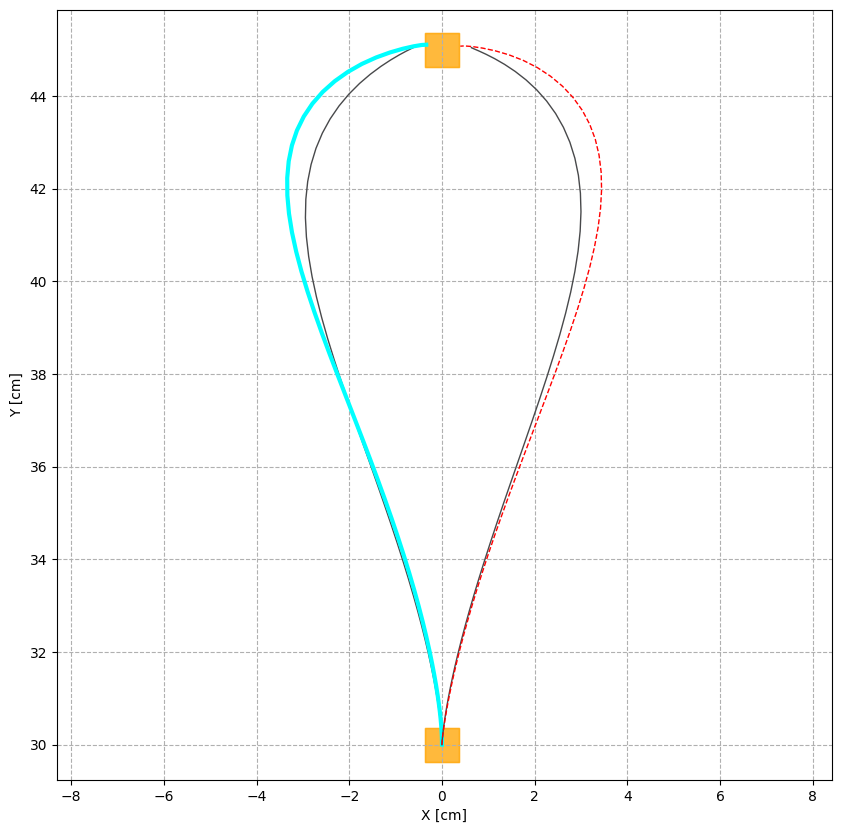

In [11]:
w = 1e6
w2 = 1e-4
plt.figure(figsize = (10,10))
for side in ["Left","Right"]:
    for delay in [0,.06]:
        X,Y = Feedback_Linearization(Duration = .6,Num_iter=60,w1 = w,w2 = w,r1=w2,r2=w2,FF = True,targets=[0,45],Side = side,FFonset=30,Delay=delay)


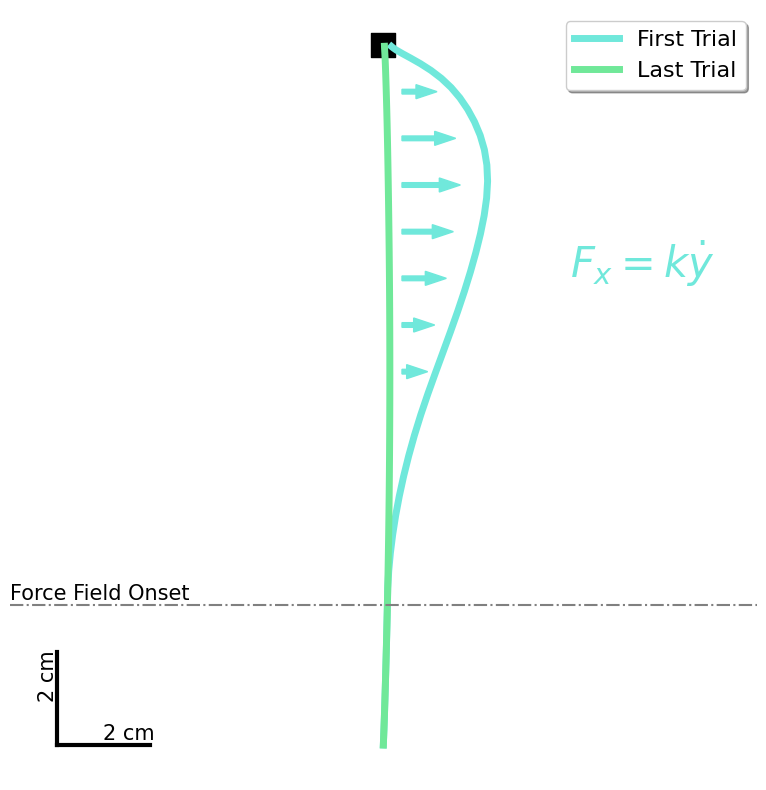

In [78]:
w = 1e6
from matplotlib.patches import FancyArrow
w2 = 1e-4
fig,ax = plt.subplots(figsize = (10,10))
Environment = {"FF":True,"Side":"Right","FFonset":33}
ax.scatter([0],[45],marker = "s",s = 300,color = "black")
X,Y = Feedback_Linearization(Duration = .6,Num_iter=60,w1 = w,w2 = w,r1=w2,r2=w2,targets=[0,45],Delay=.06,AdditionalDynamics=Environment,plot = False)
ax.plot(X,Y,color = (0.44,0.91,0.86),linewidth = 5,label = "First Trial")
X,Y = Feedback_Linearization(Duration = .6,Num_iter=60,w1 = w,w2 = w,r1=w2,r2=w2,targets=[0,45],Delay=.06,plot = False)
ax.plot(X,Y,color = (0.44,0.91,0.6),linewidth = 5,label = "Last Trial")
ax.plot(np.linspace(-8,8,100),np.ones(100)*33,color = "grey",linestyle = "-.")
ax.text(-8,33.1,"Force Field Onset",fontsize = 15)
ax.text(4,40,"$F_x=k\dot{y}$",fontsize = 30,color = (0.44,0.91,0.86))
ax.set_aspect("equal")
ax.axis("off")
ax.set_xlim(-8,8)
arrow = FancyArrow(x=0.4, y=42, dx=.8, dy=0, width=0.1, color=(0.44,0.91,0.86))
ax.add_patch(arrow)
arrow = FancyArrow(x=0.4, y=41, dx=.65, dy=0, width=0.1, color=(0.44,0.91,0.86))
ax.add_patch(arrow)
arrow = FancyArrow(x=0.4, y=40, dx=.5, dy=0, width=0.1, color=(0.44,0.91,0.86))
ax.add_patch(arrow)
arrow = FancyArrow(x=0.4, y=39, dx=.25, dy=0, width=0.1, color=(0.44,0.91,0.86))
ax.add_patch(arrow)
arrow = FancyArrow(x=0.4, y=43, dx=.7, dy=0, width=0.1, color=(0.44,0.91,0.86))
ax.add_patch(arrow)
arrow = FancyArrow(x=0.4, y=44, dx=.3, dy=0, width=0.1, color=(0.44,0.91,0.86))
ax.add_patch(arrow)
arrow = FancyArrow(x=0.4, y=38, dx=.1, dy=0, width=0.1, color=(0.44,0.91,0.86))
ax.add_patch(arrow)
plt.plot(np.ones(100)*-7,np.linspace(30,32,100),color = "black",linewidth = 3)
plt.plot(np.linspace(-7,-5,100),np.ones(100)*30,color = "black",linewidth = 3)
plt.text(-6,30.1,"2 cm",fontsize = 15)
plt.text(-7.4,31,"2 cm",fontsize = 15,rotation = 90)
MultipleLabel(title = "")